In [1]:
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import optimizers
from keras.layers import Dense
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from pandas import ExcelFile
from pandas import ExcelWriter
from PIL import Image
from scipy import ndimage
from scipy.stats import randint as sp_randint
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets
from sklearn import metrics
from sklearn import pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from tensorflow.python.framework import ops
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pandas as pd
import scipy
import tensorflow as tf
import xlsxwriter
%load_ext autoreload
%matplotlib inline
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
 
from matplotlib import pyplot as plt
%matplotlib inline
print("RDKit: %s"%rdkit.__version__)

RDKit: 2017.09.1


In [3]:
import keras
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
print("Keras: %s"%keras.__version__)

Keras: 2.2.4


In [4]:
data = pd.read_excel(r'IGC50.xlsx')

In [5]:
data["mol"] = data["smiles"].apply(Chem.MolFromSmiles)

In [6]:
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    #print(dims)
   
    #print(mol)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    cmol = Chem.Mol(mol.ToBinary())
    #print(cmol)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    #print(coords)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
            
    return vect

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(120, 120, 4)


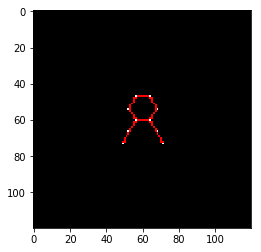

In [7]:
mol = data["mol"][104]
v = chemcepterize_mol(mol, embed=12, res=0.2)

print(v.shape)
plt.imshow(v[:,:,:3]) 

In [8]:
def vectorize(mol):
    return chemcepterize_mol(mol, embed=12,res=0.5)
data["molimage"] = data["mol"].apply(vectorize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


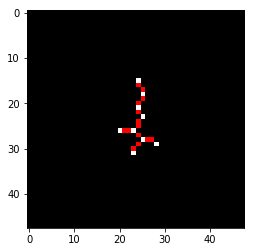

In [9]:
plt.imshow(data["molimage"][150][:,:,:3])

In [10]:
X_train = np.array(list(data["molimage"][data["split"]==1]))
X_test = np.array(list(data["molimage"][data["split"]==0]))
print(X_train.shape)
print(X_test.shape)

(1434, 48, 48, 4)
(358, 48, 48, 4)


In [11]:
assay = "Activity"  
Y_train = data[assay][data["split"]==1].values.reshape(-1,1)
Y_test = data[assay][data["split"]==0].values.reshape(-1,1)

In [12]:
print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 1434
number of test examples = 358
X_train shape: (1434, 48, 48, 4)
Y_train shape: (1434, 1)
X_test shape: (358, 48, 48, 4)
Y_test shape: (358, 1)


In [13]:
input_shape = X_train.shape[1:]
print(input_shape)

(48, 48, 4)


In [14]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###

    return X

In [15]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s=2):
    """
  

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###
    return X

In [16]:
def ResNet50(input_shape=input_shape):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    #X = Dense(10, activation='relu', kernel_initializer=glorot_uniform(seed=0))(X)
    #X = Dropout(0.1)(X)
    X = Dense(1, activation='linear', kernel_initializer=glorot_uniform(seed=0))(X)
   

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [17]:
model = ResNet50(input_shape=input_shape)

In [18]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(rotation_range=180,
                               width_shift_range=0.1,height_shift_range=0.1,
                               fill_mode="constant",cval = 0,
                               horizontal_flip=True, vertical_flip=True,data_format='channels_last',
                            
                               )



In [19]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [20]:


def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr


In [21]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

In [22]:
#Concatenate for longer epochs
Xt = np.concatenate([X_train]*50, axis=0)
yt = np.concatenate([Y_train]*50, axis=0)
 
batch_size=128

g = generator.flow(Xt, yt, batch_size=batch_size, shuffle=True)
steps_per_epoch = 10000/batch_size



callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')
    
]



history =model.fit_generator(g,
                              steps_per_epoch=len(Xt)//batch_size,
                              epochs=150,
                              validation_data=(X_test,Y_test),
                              callbacks=callbacks_list)

Epoch 1/150
560/560 [==============================] - 44s 79ms/step - loss: 1.2293 - coeff_determination: -0.1420 - lr: 2.5000e-04 - val_loss: 0.6547 - val_coeff_determination: 0.3188 - val_lr: 2.5000e-04

Epoch 00001: val_loss improved from inf to 0.65465, saving model to weights.best.hdf5
Epoch 2/150
560/560 [==============================] - 40s 72ms/step - loss: 0.6717 - coeff_determination: 0.4019 - lr: 2.5000e-04 - val_loss: 0.6009 - val_coeff_determination: 0.3808 - val_lr: 2.5000e-04

Epoch 00002: val_loss improved from 0.65465 to 0.60085, saving model to weights.best.hdf5
Epoch 3/150
560/560 [==============================] - 40s 72ms/step - loss: 0.6357 - coeff_determination: 0.4335 - lr: 2.5000e-04 - val_loss: 0.5090 - val_coeff_determination: 0.4814 - val_lr: 2.5000e-04

Epoch 00003: val_loss improved from 0.60085 to 0.50898, saving model to weights.best.hdf5
Epoch 4/150
560/560 [==============================] - 41s 73ms/step - loss: 0.6033 - coeff_determination: 0.4623 -

560/560 [==============================] - 39s 70ms/step - loss: 0.1131 - coeff_determination: 0.8985 - lr: 2.5000e-04 - val_loss: 0.3332 - val_coeff_determination: 0.6576 - val_lr: 2.5000e-04

Epoch 00030: val_loss did not improve from 0.28246
Epoch 31/150
560/560 [==============================] - 39s 70ms/step - loss: 0.1417 - coeff_determination: 0.8730 - lr: 2.5000e-04 - val_loss: 0.3928 - val_coeff_determination: 0.6029 - val_lr: 2.5000e-04

Epoch 00031: val_loss did not improve from 0.28246
Epoch 32/150
560/560 [==============================] - 39s 70ms/step - loss: 0.1840 - coeff_determination: 0.8343 - lr: 2.5000e-04 - val_loss: 0.3162 - val_coeff_determination: 0.6794 - val_lr: 2.5000e-04

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00032: val_loss did not improve from 0.28246
Epoch 33/150
560/560 [==============================] - 39s 70ms/step - loss: 0.0944 - coeff_determination: 0.9157 - lr: 1.2500e-04 - val_loss: 0.2919 - val_c

560/560 [==============================] - 39s 70ms/step - loss: 0.0140 - coeff_determination: 0.9874 - lr: 6.2500e-05 - val_loss: 0.2602 - val_coeff_determination: 0.7349 - val_lr: 6.2500e-05

Epoch 00060: val_loss did not improve from 0.25317
Epoch 61/150
560/560 [==============================] - 39s 70ms/step - loss: 0.0123 - coeff_determination: 0.9889 - lr: 6.2500e-05 - val_loss: 0.2783 - val_coeff_determination: 0.7168 - val_lr: 6.2500e-05

Epoch 00061: val_loss did not improve from 0.25317
Epoch 62/150
560/560 [==============================] - 39s 70ms/step - loss: 0.0125 - coeff_determination: 0.9888 - lr: 6.2500e-05 - val_loss: 0.2711 - val_coeff_determination: 0.7241 - val_lr: 6.2500e-05

Epoch 00062: val_loss did not improve from 0.25317
Epoch 63/150
560/560 [==============================] - 39s 70ms/step - loss: 0.0130 - coeff_determination: 0.9883 - lr: 6.2500e-05 - val_loss: 0.2797 - val_coeff_determination: 0.7156 - val_lr: 6.2500e-05

Epoch 00063: ReduceLROnPlateau r

560/560 [==============================] - 39s 70ms/step - loss: 0.0042 - coeff_determination: 0.9962 - lr: 9.7656e-07 - val_loss: 0.2601 - val_coeff_determination: 0.7363 - val_lr: 9.7656e-07

Epoch 00090: val_loss did not improve from 0.25317
Epoch 91/150
560/560 [==============================] - 39s 70ms/step - loss: 0.0042 - coeff_determination: 0.9962 - lr: 9.7656e-07 - val_loss: 0.2613 - val_coeff_determination: 0.7352 - val_lr: 9.7656e-07

Epoch 00091: val_loss did not improve from 0.25317
Epoch 92/150
560/560 [==============================] - 39s 70ms/step - loss: 0.0043 - coeff_determination: 0.9961 - lr: 9.7656e-07 - val_loss: 0.2623 - val_coeff_determination: 0.7342 - val_lr: 9.7656e-07

Epoch 00092: val_loss did not improve from 0.25317
Epoch 93/150
560/560 [==============================] - 39s 70ms/step - loss: 0.0040 - coeff_determination: 0.9964 - lr: 9.7656e-07 - val_loss: 0.2623 - val_coeff_determination: 0.7342 - val_lr: 9.7656e-07

Epoch 00093: ReduceLROnPlateau r

560/560 [==============================] - 39s 70ms/step - loss: 0.0041 - coeff_determination: 0.9964 - lr: 1.5259e-08 - val_loss: 0.2636 - val_coeff_determination: 0.7327 - val_lr: 1.5259e-08

Epoch 00120: val_loss did not improve from 0.25317
Epoch 121/150
560/560 [==============================] - 39s 70ms/step - loss: 0.0041 - coeff_determination: 0.9963 - lr: 1.5259e-08 - val_loss: 0.2636 - val_coeff_determination: 0.7327 - val_lr: 1.5259e-08

Epoch 00121: val_loss did not improve from 0.25317
Epoch 122/150
560/560 [==============================] - 39s 70ms/step - loss: 0.0041 - coeff_determination: 0.9963 - lr: 1.5259e-08 - val_loss: 0.2636 - val_coeff_determination: 0.7327 - val_lr: 1.5259e-08

Epoch 00122: val_loss did not improve from 0.25317
Epoch 123/150
560/560 [==============================] - 39s 70ms/step - loss: 0.0043 - coeff_determination: 0.9960 - lr: 1.5259e-08 - val_loss: 0.2637 - val_coeff_determination: 0.7326 - val_lr: 1.5259e-08

Epoch 00123: ReduceLROnPlatea

560/560 [==============================] - 41s 74ms/step - loss: 0.0043 - coeff_determination: 0.9961 - lr: 2.3842e-10 - val_loss: 0.2637 - val_coeff_determination: 0.7327 - val_lr: 2.3842e-10

Epoch 00150: val_loss did not improve from 0.25317


/home/abdulkarim/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


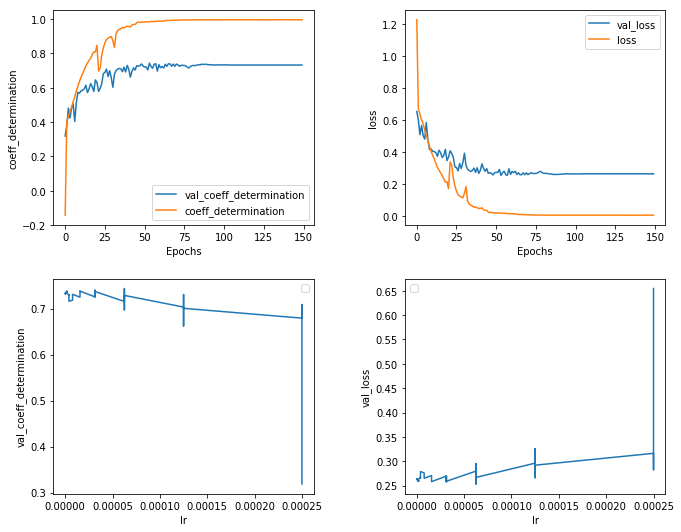

In [23]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(221)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(222)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")



plt.subplot(223)
plt.plot( hist['lr'],hist['val_coeff_determination']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_coeff_determination")


plt.subplot(224)
plt.plot( hist['lr'],hist['val_loss']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_loss")

    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

In [24]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
        json_file.write(model_json)

In [25]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model

In [26]:
loaded_model.load_weights("weights.best.hdf5")
print("Loaded model from disk")
print("  ")

Loaded model from disk
  
